# Adversarial Robustness with Error Correcting Codes
## (Never use Softmax again)

In this example we will show how using error correcting codes to convert model logits to probabilities can drastically reduce model overfitting while simultaneously increasing model robustness against adversarial attacks. In other words, why you should never use a softmax layer again. This phenomena was first publicized by the US Army in a [2019 Neurips Paper](https://papers.nips.cc/paper/9070-error-correcting-output-codes-improve-probability-estimation-and-adversarial-robustness-of-deep-neural-networks.pdf). For background on adversarial attacks, and on the attack type we will be demonstrating here, check out our [FGSM](../fgsm/fgsm.ipynb) apphub example. Note that in this apphub we will not be training against adversarial samples, but only performing adversarial attacks during evaluation to see how different models fair against them.

## Imports

In [1]:
import math
import tempfile

from tensorflow.python.keras import Sequential, layers
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.python.keras.models import Model

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.dataset.data import cifar10
from fastestimator.layers.tensorflow import HadamardCode
from fastestimator.op.numpyop.univariate import Normalize
from fastestimator.op.tensorop import Average
from fastestimator.op.tensorop.gradient import FGSM, Watch
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.summary.logs import visualize_logs
from fastestimator.trace.adapt import EarlyStopping
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy

In [2]:
# training parameters
epsilon=0.04  # The strength of the adversarial attack
epochs=60
batch_size=50
log_steps=500
max_train_steps_per_epoch=None
max_eval_steps_per_epoch=None
save_dir=tempfile.mkdtemp()

In [3]:
# Parameters
epochs = 2
batch_size = 8
max_train_steps_per_epoch = 10
max_eval_steps_per_epoch = 10


## Getting the Data
For these experiments we will be using the CIFAR-10 Dataset

In [4]:
train_data, eval_data = cifar10.load_data()
test_data = eval_data.split(0.5)
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))])

     8192/170498071 [..............................] - ETA: 28:04

    40960/170498071 [..............................] - ETA: 11:18

    90112/170498071 [..............................] - ETA: 7:43 

   221184/170498071 [..............................] - ETA: 4:11

   385024/170498071 [..............................] - ETA: 3:50

   729088/170498071 [..............................] - ETA: 2:13

   991232/170498071 [..............................] - ETA: 1:59

  1105920/170498071 [..............................] - ETA: 1:58

  1286144/170498071 [..............................] - ETA: 1:54

  1482752/170498071 [..............................] - ETA: 1:47

  1597440/170498071 [..............................] - ETA: 1:44

  1728512/170498071 [..............................] - ETA: 1:44

  1810432/170498071 [..............................] - ETA: 1:44

  1892352/170498071 [..............................] - ETA: 1:45

  2007040/170498071 [..............................] - ETA: 1:43

  2072576/170498071 [..............................] - ETA: 1:44

  2170880/170498071 [..............................] - ETA: 1:44

  2301952/170498071 [..............................] - ETA: 1:42

  2383872/170498071 [..............................] - ETA: 1:42

  2465792/170498071 [..............................] - ETA: 1:43

  2580480/170498071 [..............................] - ETA: 1:41

  2646016/170498071 [..............................] - ETA: 1:42

  2760704/170498071 [..............................] - ETA: 1:42

  2875392/170498071 [..............................] - ETA: 1:40

  2940928/170498071 [..............................] - ETA: 1:41

  3055616/170498071 [..............................] - ETA: 1:41

  3186688/170498071 [..............................] - ETA: 1:39

  3268608/170498071 [..............................] - ETA: 1:40

  3366912/170498071 [..............................] - ETA: 1:39

  3481600/170498071 [..............................] - ETA: 1:38

  3547136/170498071 [..............................] - ETA: 1:39

  3661824/170498071 [..............................] - ETA: 1:38

  3792896/170498071 [..............................] - ETA: 1:37

  3858432/170498071 [..............................] - ETA: 1:38

  3989504/170498071 [..............................] - ETA: 1:37

  4120576/170498071 [..............................] - ETA: 1:36

  4202496/170498071 [..............................] - ETA: 1:37

  4300800/170498071 [..............................] - ETA: 1:36

  4431872/170498071 [..............................] - ETA: 1:36

  4513792/170498071 [..............................] - ETA: 1:36

  4612096/170498071 [..............................] - ETA: 1:35

  4759552/170498071 [..............................] - ETA: 1:35

  4841472/170498071 [..............................] - ETA: 1:35

  4939776/170498071 [..............................] - ETA: 1:35

  5070848/170498071 [..............................] - ETA: 1:34

  5152768/170498071 [..............................] - ETA: 1:34

  5267456/170498071 [..............................] - ETA: 1:34

  5398528/170498071 [..............................] - ETA: 1:33

  5480448/170498071 [..............................] - ETA: 1:33

  5578752/170498071 [..............................] - ETA: 1:33

  5726208/170498071 [>.............................] - ETA: 1:32

  5808128/170498071 [>.............................] - ETA: 1:32

  5906432/170498071 [>.............................] - ETA: 1:32

  6053888/170498071 [>.............................] - ETA: 1:32

  6135808/170498071 [>.............................] - ETA: 1:32

  6234112/170498071 [>.............................] - ETA: 1:32

  6365184/170498071 [>.............................] - ETA: 1:31

  6447104/170498071 [>.............................] - ETA: 1:31

  6561792/170498071 [>.............................] - ETA: 1:31

  6692864/170498071 [>.............................] - ETA: 1:30

  6791168/170498071 [>.............................] - ETA: 1:30

  6889472/170498071 [>.............................] - ETA: 1:30

  7020544/170498071 [>.............................] - ETA: 1:30

  7102464/170498071 [>.............................] - ETA: 1:30

  7217152/170498071 [>.............................] - ETA: 1:30

  7331840/170498071 [>.............................] - ETA: 1:29

  7430144/170498071 [>.............................] - ETA: 1:29

  7528448/170498071 [>.............................] - ETA: 1:29

  7643136/170498071 [>.............................] - ETA: 1:29

  7741440/170498071 [>.............................] - ETA: 1:29

  7856128/170498071 [>.............................] - ETA: 1:29

  7970816/170498071 [>.............................] - ETA: 1:28

  8069120/170498071 [>.............................] - ETA: 1:28

  8183808/170498071 [>.............................] - ETA: 1:28

  8314880/170498071 [>.............................] - ETA: 1:28

  8413184/170498071 [>.............................] - ETA: 1:28

  8527872/170498071 [>.............................] - ETA: 1:28

  8642560/170498071 [>.............................] - ETA: 1:27

  8740864/170498071 [>.............................] - ETA: 1:27

  8871936/170498071 [>.............................] - ETA: 1:27

  9019392/170498071 [>.............................] - ETA: 1:27

  9134080/170498071 [>.............................] - ETA: 1:27

  9248768/170498071 [>.............................] - ETA: 1:27

  9363456/170498071 [>.............................] - ETA: 1:26

  9494528/170498071 [>.............................] - ETA: 1:26

  9592832/170498071 [>.............................] - ETA: 1:26

  9723904/170498071 [>.............................] - ETA: 1:26

  9871360/170498071 [>.............................] - ETA: 1:25

  9953280/170498071 [>.............................] - ETA: 1:26

 10084352/170498071 [>.............................] - ETA: 1:25

 10215424/170498071 [>.............................] - ETA: 1:25

 10280960/170498071 [>.............................] - ETA: 1:25

 10428416/170498071 [>.............................] - ETA: 1:25

 10575872/170498071 [>.............................] - ETA: 1:24

 10690560/170498071 [>.............................] - ETA: 1:24

 10788864/170498071 [>.............................] - ETA: 1:24

 10919936/170498071 [>.............................] - ETA: 1:24

 11051008/170498071 [>.............................] - ETA: 1:24

 11165696/170498071 [>.............................] - ETA: 1:24

 11313152/170498071 [>.............................] - ETA: 1:23

 11460608/170498071 [=>............................] - ETA: 1:23

 11526144/170498071 [=>............................] - ETA: 1:23

 11608064/170498071 [=>............................] - ETA: 1:24

 11853824/170498071 [=>............................] - ETA: 1:23

 11968512/170498071 [=>............................] - ETA: 1:23

 12099584/170498071 [=>............................] - ETA: 1:23

 12230656/170498071 [=>............................] - ETA: 1:24

 12378112/170498071 [=>............................] - ETA: 1:24

 12509184/170498071 [=>............................] - ETA: 1:24

 12656640/170498071 [=>............................] - ETA: 1:24

 12787712/170498071 [=>............................] - ETA: 1:24

 12935168/170498071 [=>............................] - ETA: 1:24

 13082624/170498071 [=>............................] - ETA: 1:24

 13230080/170498071 [=>............................] - ETA: 1:23

 13393920/170498071 [=>............................] - ETA: 1:23

 13541376/170498071 [=>............................] - ETA: 1:23

 13688832/170498071 [=>............................] - ETA: 1:23

 13852672/170498071 [=>............................] - ETA: 1:23

 14016512/170498071 [=>............................] - ETA: 1:23

 14163968/170498071 [=>............................] - ETA: 1:23

 14327808/170498071 [=>............................] - ETA: 1:23

 14491648/170498071 [=>............................] - ETA: 1:23

 14655488/170498071 [=>............................] - ETA: 1:22

 14819328/170498071 [=>............................] - ETA: 1:22

 14983168/170498071 [=>............................] - ETA: 1:22

 15147008/170498071 [=>............................] - ETA: 1:22

 15327232/170498071 [=>............................] - ETA: 1:22

 15491072/170498071 [=>............................] - ETA: 1:22

 15671296/170498071 [=>............................] - ETA: 1:21

 15835136/170498071 [=>............................] - ETA: 1:21

 16015360/170498071 [=>............................] - ETA: 1:21

 16179200/170498071 [=>............................] - ETA: 1:21

 16359424/170498071 [=>............................] - ETA: 1:21

 16539648/170498071 [=>............................] - ETA: 1:20

 16719872/170498071 [=>............................] - ETA: 1:20

 16883712/170498071 [=>............................] - ETA: 1:20

 17063936/170498071 [==>...........................] - ETA: 1:20

 17244160/170498071 [==>...........................] - ETA: 1:20

 17424384/170498071 [==>...........................] - ETA: 1:20

 17604608/170498071 [==>...........................] - ETA: 1:19

 17784832/170498071 [==>...........................] - ETA: 1:19

 17965056/170498071 [==>...........................] - ETA: 1:19

 18145280/170498071 [==>...........................] - ETA: 1:19

 18325504/170498071 [==>...........................] - ETA: 1:19

 18505728/170498071 [==>...........................] - ETA: 1:18

 18685952/170498071 [==>...........................] - ETA: 1:18

 18866176/170498071 [==>...........................] - ETA: 1:18

 19046400/170498071 [==>...........................] - ETA: 1:18

 19226624/170498071 [==>...........................] - ETA: 1:18

 19390464/170498071 [==>...........................] - ETA: 1:18

 19587072/170498071 [==>...........................] - ETA: 1:17

 19767296/170498071 [==>...........................] - ETA: 1:17

 19947520/170498071 [==>...........................] - ETA: 1:17

 20127744/170498071 [==>...........................] - ETA: 1:17

 20307968/170498071 [==>...........................] - ETA: 1:17

 20488192/170498071 [==>...........................] - ETA: 1:16

 20668416/170498071 [==>...........................] - ETA: 1:16

 20848640/170498071 [==>...........................] - ETA: 1:16

 21028864/170498071 [==>...........................] - ETA: 1:16

 21209088/170498071 [==>...........................] - ETA: 1:16

 21389312/170498071 [==>...........................] - ETA: 1:16

 21569536/170498071 [==>...........................] - ETA: 1:15

 21749760/170498071 [==>...........................] - ETA: 1:15

 21929984/170498071 [==>...........................] - ETA: 1:15

 22110208/170498071 [==>...........................] - ETA: 1:15

 22290432/170498071 [==>...........................] - ETA: 1:15

 22470656/170498071 [==>...........................] - ETA: 1:15

 22650880/170498071 [==>...........................] - ETA: 1:15

 22831104/170498071 [===>..........................] - ETA: 1:14

 23011328/170498071 [===>..........................] - ETA: 1:14

 23191552/170498071 [===>..........................] - ETA: 1:14

 23371776/170498071 [===>..........................] - ETA: 1:14

 23552000/170498071 [===>..........................] - ETA: 1:14

 23732224/170498071 [===>..........................] - ETA: 1:14

 23912448/170498071 [===>..........................] - ETA: 1:13

 24092672/170498071 [===>..........................] - ETA: 1:13

 24240128/170498071 [===>..........................] - ETA: 1:14

 24469504/170498071 [===>..........................] - ETA: 1:13

 24584192/170498071 [===>..........................] - ETA: 1:13

 24715264/170498071 [===>..........................] - ETA: 1:13

 24846336/170498071 [===>..........................] - ETA: 1:13

 24944640/170498071 [===>..........................] - ETA: 1:13

 25026560/170498071 [===>..........................] - ETA: 1:13

 25124864/170498071 [===>..........................] - ETA: 1:13

 25255936/170498071 [===>..........................] - ETA: 1:13

 25370624/170498071 [===>..........................] - ETA: 1:13

 25452544/170498071 [===>..........................] - ETA: 1:13

 25567232/170498071 [===>..........................] - ETA: 1:13

 25714688/170498071 [===>..........................] - ETA: 1:13

 25845760/170498071 [===>..........................] - ETA: 1:13

 25960448/170498071 [===>..........................] - ETA: 1:13

 26058752/170498071 [===>..........................] - ETA: 1:13

 26173440/170498071 [===>..........................] - ETA: 1:13

 26320896/170498071 [===>..........................] - ETA: 1:13

 26435584/170498071 [===>..........................] - ETA: 1:13

 26517504/170498071 [===>..........................] - ETA: 1:13

 26648576/170498071 [===>..........................] - ETA: 1:13

 26796032/170498071 [===>..........................] - ETA: 1:13

 26910720/170498071 [===>..........................] - ETA: 1:13

 27009024/170498071 [===>..........................] - ETA: 1:13

 27140096/170498071 [===>..........................] - ETA: 1:13

 27287552/170498071 [===>..........................] - ETA: 1:12

 27402240/170498071 [===>..........................] - ETA: 1:12

 27500544/170498071 [===>..........................] - ETA: 1:12

 27631616/170498071 [===>..........................] - ETA: 1:12

 27762688/170498071 [===>..........................] - ETA: 1:12

 27893760/170498071 [===>..........................] - ETA: 1:12

 27975680/170498071 [===>..........................] - ETA: 1:12

 28106752/170498071 [===>..........................] - ETA: 1:12

 28237824/170498071 [===>..........................] - ETA: 1:12

 28319744/170498071 [===>..........................] - ETA: 1:12

 28450816/170498071 [====>.........................] - ETA: 1:12

 28581888/170498071 [====>.........................] - ETA: 1:11

 28680192/170498071 [====>.........................] - ETA: 1:12

 28827648/170498071 [====>.........................] - ETA: 1:11

 28958720/170498071 [====>.........................] - ETA: 1:11

 29073408/170498071 [====>.........................] - ETA: 1:11

 29188096/170498071 [====>.........................] - ETA: 1:11

 29302784/170498071 [====>.........................] - ETA: 1:11

 29417472/170498071 [====>.........................] - ETA: 1:11

 29532160/170498071 [====>.........................] - ETA: 1:11

 29663232/170498071 [====>.........................] - ETA: 1:11

 29769728/170498071 [====>.........................] - ETA: 1:11

 29892608/170498071 [====>.........................] - ETA: 1:11

 30023680/170498071 [====>.........................] - ETA: 1:10

 30138368/170498071 [====>.........................] - ETA: 1:10

 30269440/170498071 [====>.........................] - ETA: 1:10

 30433280/170498071 [====>.........................] - ETA: 1:10

 30547968/170498071 [====>.........................] - ETA: 1:10

 30629888/170498071 [====>.........................] - ETA: 1:10

 30793728/170498071 [====>.........................] - ETA: 1:10

 30908416/170498071 [====>.........................] - ETA: 1:10

 30990336/170498071 [====>.........................] - ETA: 1:10

 31154176/170498071 [====>.........................] - ETA: 1:10

 31252480/170498071 [====>.........................] - ETA: 1:10

 31367168/170498071 [====>.........................] - ETA: 1:10

 31514624/170498071 [====>.........................] - ETA: 1:09

 31612928/170498071 [====>.........................] - ETA: 1:09

 31727616/170498071 [====>.........................] - ETA: 1:09

 31875072/170498071 [====>.........................] - ETA: 1:09

 31973376/170498071 [====>.........................] - ETA: 1:09

 32088064/170498071 [====>.........................] - ETA: 1:09

 32235520/170498071 [====>.........................] - ETA: 1:09

 32333824/170498071 [====>.........................] - ETA: 1:09

 32448512/170498071 [====>.........................] - ETA: 1:09

 32595968/170498071 [====>.........................] - ETA: 1:09

 32694272/170498071 [====>.........................] - ETA: 1:09

 32808960/170498071 [====>.........................] - ETA: 1:09

 32956416/170498071 [====>.........................] - ETA: 1:08

 33054720/170498071 [====>.........................] - ETA: 1:08

 33169408/170498071 [====>.........................] - ETA: 1:08

 33316864/170498071 [====>.........................] - ETA: 1:08

 33415168/170498071 [====>.........................] - ETA: 1:08

 33529856/170498071 [====>.........................] - ETA: 1:08

 33677312/170498071 [====>.........................] - ETA: 1:08

 33759232/170498071 [====>.........................] - ETA: 1:08

 33890304/170498071 [====>.........................] - ETA: 1:08

 33955840/170498071 [====>.........................] - ETA: 1:08

 34119680/170498071 [=====>........................] - ETA: 1:08

 34250752/170498071 [=====>........................] - ETA: 1:08

 34332672/170498071 [=====>........................] - ETA: 1:08

 34480128/170498071 [=====>........................] - ETA: 1:07

 34627584/170498071 [=====>........................] - ETA: 1:07

 34725888/170498071 [=====>........................] - ETA: 1:07

 34840576/170498071 [=====>........................] - ETA: 1:07

 34988032/170498071 [=====>........................] - ETA: 1:07

 35069952/170498071 [=====>........................] - ETA: 1:07

 35217408/170498071 [=====>........................] - ETA: 1:07

 35381248/170498071 [=====>........................] - ETA: 1:07

 35479552/170498071 [=====>........................] - ETA: 1:07

 35594240/170498071 [=====>........................] - ETA: 1:07

 35758080/170498071 [=====>........................] - ETA: 1:07

 35889152/170498071 [=====>........................] - ETA: 1:06

 35954688/170498071 [=====>........................] - ETA: 1:07

 36118528/170498071 [=====>........................] - ETA: 1:06

 36249600/170498071 [=====>........................] - ETA: 1:06

 36331520/170498071 [=====>........................] - ETA: 1:06

 36478976/170498071 [=====>........................] - ETA: 1:06

 36610048/170498071 [=====>........................] - ETA: 1:06

 36691968/170498071 [=====>........................] - ETA: 1:06

 36855808/170498071 [=====>........................] - ETA: 1:06

 36986880/170498071 [=====>........................] - ETA: 1:06

 37085184/170498071 [=====>........................] - ETA: 1:06

 37216256/170498071 [=====>........................] - ETA: 1:06

 37363712/170498071 [=====>........................] - ETA: 1:06

 37462016/170498071 [=====>........................] - ETA: 1:05

 37593088/170498071 [=====>........................] - ETA: 1:05

 37724160/170498071 [=====>........................] - ETA: 1:05

 37822464/170498071 [=====>........................] - ETA: 1:05

 37953536/170498071 [=====>........................] - ETA: 1:05

 38100992/170498071 [=====>........................] - ETA: 1:05

 38199296/170498071 [=====>........................] - ETA: 1:05

 38330368/170498071 [=====>........................] - ETA: 1:05

 38461440/170498071 [=====>........................] - ETA: 1:05

 38576128/170498071 [=====>........................] - ETA: 1:05

 38707200/170498071 [=====>........................] - ETA: 1:05

 38854656/170498071 [=====>........................] - ETA: 1:05

 38969344/170498071 [=====>........................] - ETA: 1:04

 39100416/170498071 [=====>........................] - ETA: 1:04

 39247872/170498071 [=====>........................] - ETA: 1:04

 39346176/170498071 [=====>........................] - ETA: 1:04

 39477248/170498071 [=====>........................] - ETA: 1:04

 39641088/170498071 [=====>........................] - ETA: 1:04

 39739392/170498071 [=====>........................] - ETA: 1:04

 39870464/170498071 [======>.......................] - ETA: 1:04

 40034304/170498071 [======>.......................] - ETA: 1:04

 40148992/170498071 [======>.......................] - ETA: 1:04

 40263680/170498071 [======>.......................] - ETA: 1:04

 40427520/170498071 [======>.......................] - ETA: 1:03

 40574976/170498071 [======>.......................] - ETA: 1:03

 40706048/170498071 [======>.......................] - ETA: 1:03

 40837120/170498071 [======>.......................] - ETA: 1:03

 40984576/170498071 [======>.......................] - ETA: 1:03

 41099264/170498071 [======>.......................] - ETA: 1:03

 41230336/170498071 [======>.......................] - ETA: 1:03

 41377792/170498071 [======>.......................] - ETA: 1:03

 41508864/170498071 [======>.......................] - ETA: 1:03

 41639936/170498071 [======>.......................] - ETA: 1:03

 41787392/170498071 [======>.......................] - ETA: 1:02

 41918464/170498071 [======>.......................] - ETA: 1:02

 42049536/170498071 [======>.......................] - ETA: 1:02

 42213376/170498071 [======>.......................] - ETA: 1:02

 42344448/170498071 [======>.......................] - ETA: 1:02

 42475520/170498071 [======>.......................] - ETA: 1:02

 42639360/170498071 [======>.......................] - ETA: 1:02

 42786816/170498071 [======>.......................] - ETA: 1:02

 42934272/170498071 [======>.......................] - ETA: 1:01

 43114496/170498071 [======>.......................] - ETA: 1:01

 43245568/170498071 [======>.......................] - ETA: 1:01

 43393024/170498071 [======>.......................] - ETA: 1:01

 43556864/170498071 [======>.......................] - ETA: 1:01

 43687936/170498071 [======>.......................] - ETA: 1:01

 43835392/170498071 [======>.......................] - ETA: 1:01

 43999232/170498071 [======>.......................] - ETA: 1:01

 44146688/170498071 [======>.......................] - ETA: 1:00

 44310528/170498071 [======>.......................] - ETA: 1:00

 44474368/170498071 [======>.......................] - ETA: 1:00

 44621824/170498071 [======>.......................] - ETA: 1:00

 44785664/170498071 [======>.......................] - ETA: 1:00

 44949504/170498071 [======>.......................] - ETA: 1:00

 45096960/170498071 [======>.......................] - ETA: 1:00

 45260800/170498071 [======>.......................] - ETA: 1:00

 45441024/170498071 [======>.......................] - ETA: 59s 

 45588480/170498071 [=======>......................] - ETA: 59s

 45744128/170498071 [=======>......................] - ETA: 59s

 45932544/170498071 [=======>......................] - ETA: 59s

 46096384/170498071 [=======>......................] - ETA: 59s

 46260224/170498071 [=======>......................] - ETA: 59s

 46456832/170498071 [=======>......................] - ETA: 58s

 46604288/170498071 [=======>......................] - ETA: 58s

 46784512/170498071 [=======>......................] - ETA: 58s

 47030272/170498071 [=======>......................] - ETA: 58s

 47259648/170498071 [=======>......................] - ETA: 58s

 47423488/170498071 [=======>......................] - ETA: 58s

 47587328/170498071 [=======>......................] - ETA: 57s

 47816704/170498071 [=======>......................] - ETA: 57s

 47947776/170498071 [=======>......................] - ETA: 57s

 48128000/170498071 [=======>......................] - ETA: 57s

 48373760/170498071 [=======>......................] - ETA: 57s

 48521216/170498071 [=======>......................] - ETA: 57s

 48734208/170498071 [=======>......................] - ETA: 56s

 48963584/170498071 [=======>......................] - ETA: 56s

 49061888/170498071 [=======>......................] - ETA: 56s

 49307648/170498071 [=======>......................] - ETA: 56s

 49569792/170498071 [=======>......................] - ETA: 56s

 49668096/170498071 [=======>......................] - ETA: 55s

 49913856/170498071 [=======>......................] - ETA: 55s

 50126848/170498071 [=======>......................] - ETA: 55s

 50307072/170498071 [=======>......................] - ETA: 55s

 50569216/170498071 [=======>......................] - ETA: 55s

 50847744/170498071 [=======>......................] - ETA: 54s

 50962432/170498071 [=======>......................] - ETA: 54s

 51224576/170498071 [========>.....................] - ETA: 54s

 51404800/170498071 [========>.....................] - ETA: 54s

 51609600/170498071 [========>.....................] - ETA: 54s

 51896320/170498071 [========>.....................] - ETA: 53s

 52060160/170498071 [========>.....................] - ETA: 53s

 52289536/170498071 [========>.....................] - ETA: 53s

 52584448/170498071 [========>.....................] - ETA: 53s

 52715520/170498071 [========>.....................] - ETA: 53s

 53010432/170498071 [========>.....................] - ETA: 52s

 53239808/170498071 [========>.....................] - ETA: 52s

 53272576/170498071 [========>.....................] - ETA: 52s

 53780480/170498071 [========>.....................] - ETA: 52s

 53960704/170498071 [========>.....................] - ETA: 51s

 54124544/170498071 [========>.....................] - ETA: 51s

 54288384/170498071 [========>.....................] - ETA: 51s

 54517760/170498071 [========>.....................] - ETA: 51s

 54681600/170498071 [========>.....................] - ETA: 51s

 54878208/170498071 [========>.....................] - ETA: 51s

 55074816/170498071 [========>.....................] - ETA: 51s

 55238656/170498071 [========>.....................] - ETA: 50s

 55435264/170498071 [========>.....................] - ETA: 50s

 55664640/170498071 [========>.....................] - ETA: 50s

 55861248/170498071 [========>.....................] - ETA: 50s

 56074240/170498071 [========>.....................] - ETA: 50s

 56254464/170498071 [========>.....................] - ETA: 50s

 56418304/170498071 [========>.....................] - ETA: 50s

 56614912/170498071 [========>.....................] - ETA: 49s

 56836096/170498071 [=========>....................] - ETA: 49s

 57008128/170498071 [=========>....................] - ETA: 49s

 57221120/170498071 [=========>....................] - ETA: 49s

 57434112/170498071 [=========>....................] - ETA: 49s

 57630720/170498071 [=========>....................] - ETA: 49s

 57827328/170498071 [=========>....................] - ETA: 48s

 58023936/170498071 [=========>....................] - ETA: 48s

 58253312/170498071 [=========>....................] - ETA: 48s

 58466304/170498071 [=========>....................] - ETA: 48s

 58679296/170498071 [=========>....................] - ETA: 48s

 58875904/170498071 [=========>....................] - ETA: 48s

 59121664/170498071 [=========>....................] - ETA: 47s

 59334656/170498071 [=========>....................] - ETA: 47s

 59547648/170498071 [=========>....................] - ETA: 47s

 59777024/170498071 [=========>....................] - ETA: 47s

 59973632/170498071 [=========>....................] - ETA: 47s

 60186624/170498071 [=========>....................] - ETA: 47s

 60448768/170498071 [=========>....................] - ETA: 46s

 60612608/170498071 [=========>....................] - ETA: 46s

 60841984/170498071 [=========>....................] - ETA: 46s

 61038592/170498071 [=========>....................] - ETA: 46s

 61251584/170498071 [=========>....................] - ETA: 46s

 61497344/170498071 [=========>....................] - ETA: 46s

 61693952/170498071 [=========>....................] - ETA: 46s

 61923328/170498071 [=========>....................] - ETA: 45s

 62152704/170498071 [=========>....................] - ETA: 45s

 62382080/170498071 [=========>....................] - ETA: 45s

 62595072/170498071 [==========>...................] - ETA: 45s

 62824448/170498071 [==========>...................] - ETA: 45s

 63070208/170498071 [==========>...................] - ETA: 44s

 63299584/170498071 [==========>...................] - ETA: 44s

 63512576/170498071 [==========>...................] - ETA: 44s

 63709184/170498071 [==========>...................] - ETA: 44s

 63954944/170498071 [==========>...................] - ETA: 44s

 64184320/170498071 [==========>...................] - ETA: 44s

 64413696/170498071 [==========>...................] - ETA: 43s

 64643072/170498071 [==========>...................] - ETA: 43s

 64856064/170498071 [==========>...................] - ETA: 43s

 65101824/170498071 [==========>...................] - ETA: 43s

 65282048/170498071 [==========>...................] - ETA: 43s

 65544192/170498071 [==========>...................] - ETA: 43s

 65757184/170498071 [==========>...................] - ETA: 43s

 66002944/170498071 [==========>...................] - ETA: 42s

 66199552/170498071 [==========>...................] - ETA: 42s

 66265088/170498071 [==========>...................] - ETA: 42s

 66445312/170498071 [==========>...................] - ETA: 42s

 66936832/170498071 [==========>...................] - ETA: 42s

 67149824/170498071 [==========>...................] - ETA: 42s

 67346432/170498071 [==========>...................] - ETA: 42s

 67461120/170498071 [==========>...................] - ETA: 42s

 67706880/170498071 [==========>...................] - ETA: 41s

 67887104/170498071 [==========>...................] - ETA: 41s

 68001792/170498071 [==========>...................] - ETA: 41s

 68231168/170498071 [===========>..................] - ETA: 41s

 68395008/170498071 [===========>..................] - ETA: 41s

 68542464/170498071 [===========>..................] - ETA: 41s

 68788224/170498071 [===========>..................] - ETA: 41s

 68919296/170498071 [===========>..................] - ETA: 41s

 69099520/170498071 [===========>..................] - ETA: 41s

 69361664/170498071 [===========>..................] - ETA: 40s

 69509120/170498071 [===========>..................] - ETA: 40s

 69656576/170498071 [===========>..................] - ETA: 40s

 69902336/170498071 [===========>..................] - ETA: 40s

 70033408/170498071 [===========>..................] - ETA: 40s

 70230016/170498071 [===========>..................] - ETA: 40s

 70483968/170498071 [===========>..................] - ETA: 40s

 70623232/170498071 [===========>..................] - ETA: 40s

 70819840/170498071 [===========>..................] - ETA: 40s

 71065600/170498071 [===========>..................] - ETA: 39s

 71245824/170498071 [===========>..................] - ETA: 39s

 71393280/170498071 [===========>..................] - ETA: 39s

 71655424/170498071 [===========>..................] - ETA: 39s

 71786496/170498071 [===========>..................] - ETA: 39s

 71983104/170498071 [===========>..................] - ETA: 39s

 72261632/170498071 [===========>..................] - ETA: 39s

 72392704/170498071 [===========>..................] - ETA: 39s

 72589312/170498071 [===========>..................] - ETA: 39s

 72867840/170498071 [===========>..................] - ETA: 38s

 73015296/170498071 [===========>..................] - ETA: 38s

 73179136/170498071 [===========>..................] - ETA: 38s

 73457664/170498071 [===========>..................] - ETA: 38s

 73588736/170498071 [===========>..................] - ETA: 38s

 73785344/170498071 [===========>..................] - ETA: 38s

 74063872/170498071 [============>.................] - ETA: 38s

 74211328/170498071 [============>.................] - ETA: 38s

 74375168/170498071 [============>.................] - ETA: 38s

 74670080/170498071 [============>.................] - ETA: 37s

 74801152/170498071 [============>.................] - ETA: 37s

 74981376/170498071 [============>.................] - ETA: 37s

 75276288/170498071 [============>.................] - ETA: 37s

 75554816/170498071 [============>.................] - ETA: 37s

 75685888/170498071 [============>.................] - ETA: 37s

 75898880/170498071 [============>.................] - ETA: 37s

 76161024/170498071 [============>.................] - ETA: 37s

 76275712/170498071 [============>.................] - ETA: 37s

 76505088/170498071 [============>.................] - ETA: 36s

 76783616/170498071 [============>.................] - ETA: 36s

 76881920/170498071 [============>.................] - ETA: 36s

 77111296/170498071 [============>.................] - ETA: 36s

 77307904/170498071 [============>.................] - ETA: 36s

 77447168/170498071 [============>.................] - ETA: 36s

 77717504/170498071 [============>.................] - ETA: 36s

 77832192/170498071 [============>.................] - ETA: 36s

 78045184/170498071 [============>.................] - ETA: 36s

 78290944/170498071 [============>.................] - ETA: 35s

 78422016/170498071 [============>.................] - ETA: 35s

 78667776/170498071 [============>.................] - ETA: 35s

 78897152/170498071 [============>.................] - ETA: 35s

 79036416/170498071 [============>.................] - ETA: 35s

 79290368/170498071 [============>.................] - ETA: 35s

 79536128/170498071 [============>.................] - ETA: 35s

 79667200/170498071 [=============>................] - ETA: 35s

 79912960/170498071 [=============>................] - ETA: 35s

 80158720/170498071 [=============>................] - ETA: 34s

 80306176/170498071 [=============>................] - ETA: 34s

 80551936/170498071 [=============>................] - ETA: 34s

 80764928/170498071 [=============>................] - ETA: 34s

 80928768/170498071 [=============>................] - ETA: 34s

 81190912/170498071 [=============>................] - ETA: 34s

 81436672/170498071 [=============>................] - ETA: 34s

 81584128/170498071 [=============>................] - ETA: 34s

 81829888/170498071 [=============>................] - ETA: 34s

 82108416/170498071 [=============>................] - ETA: 33s

 82223104/170498071 [=============>................] - ETA: 33s

 82468864/170498071 [=============>................] - ETA: 33s

 82698240/170498071 [=============>................] - ETA: 33s

 82862080/170498071 [=============>................] - ETA: 33s

 83107840/170498071 [=============>................] - ETA: 33s

 83304448/170498071 [=============>................] - ETA: 33s

 83484672/170498071 [=============>................] - ETA: 33s

 83763200/170498071 [=============>................] - ETA: 33s

 83976192/170498071 [=============>................] - ETA: 33s

 84156416/170498071 [=============>................] - ETA: 32s

 84221952/170498071 [=============>................] - ETA: 32s

 84336640/170498071 [=============>................] - ETA: 32s

 84418560/170498071 [=============>................] - ETA: 32s

 84467712/170498071 [=============>................] - ETA: 33s

 85123072/170498071 [=============>................] - ETA: 32s

 85237760/170498071 [=============>................] - ETA: 32s

 85434368/170498071 [==============>...............] - ETA: 32s

 85598208/170498071 [==============>...............] - ETA: 32s

 85712896/170498071 [==============>...............] - ETA: 32s

 85893120/170498071 [==============>...............] - ETA: 32s

 86056960/170498071 [==============>...............] - ETA: 32s

 86188032/170498071 [==============>...............] - ETA: 32s

 86384640/170498071 [==============>...............] - ETA: 32s

 86564864/170498071 [==============>...............] - ETA: 31s

 86695936/170498071 [==============>...............] - ETA: 31s

 86892544/170498071 [==============>...............] - ETA: 31s

 87089152/170498071 [==============>...............] - ETA: 31s

 87212032/170498071 [==============>...............] - ETA: 31s

 87416832/170498071 [==============>...............] - ETA: 31s

 87597056/170498071 [==============>...............] - ETA: 31s

 87744512/170498071 [==============>...............] - ETA: 31s

 87941120/170498071 [==============>...............] - ETA: 31s

 88137728/170498071 [==============>...............] - ETA: 31s

 88285184/170498071 [==============>...............] - ETA: 31s

 88498176/170498071 [==============>...............] - ETA: 31s

 88694784/170498071 [==============>...............] - ETA: 31s

 88825856/170498071 [==============>...............] - ETA: 30s

 89055232/170498071 [==============>...............] - ETA: 30s

 89251840/170498071 [==============>...............] - ETA: 30s

 89399296/170498071 [==============>...............] - ETA: 30s

 89612288/170498071 [==============>...............] - ETA: 30s

 89841664/170498071 [==============>...............] - ETA: 30s

 89989120/170498071 [==============>...............] - ETA: 30s

 90202112/170498071 [==============>...............] - ETA: 30s

 90415104/170498071 [==============>...............] - ETA: 30s

 90562560/170498071 [==============>...............] - ETA: 30s

 90775552/170498071 [==============>...............] - ETA: 30s

 90923008/170498071 [==============>...............] - ETA: 30s

 91004928/170498071 [===============>..............] - ETA: 30s

 91430912/170498071 [===============>..............] - ETA: 29s

 91594752/170498071 [===============>..............] - ETA: 29s

 91725824/170498071 [===============>..............] - ETA: 29s

 91856896/170498071 [===============>..............] - ETA: 29s

 92037120/170498071 [===============>..............] - ETA: 29s

 92151808/170498071 [===============>..............] - ETA: 29s

 92282880/170498071 [===============>..............] - ETA: 29s

 92463104/170498071 [===============>..............] - ETA: 29s

 92610560/170498071 [===============>..............] - ETA: 29s

 92725248/170498071 [===============>..............] - ETA: 29s

 92905472/170498071 [===============>..............] - ETA: 29s

 93052928/170498071 [===============>..............] - ETA: 29s

 93184000/170498071 [===============>..............] - ETA: 29s

 93364224/170498071 [===============>..............] - ETA: 29s

 93511680/170498071 [===============>..............] - ETA: 29s

 93626368/170498071 [===============>..............] - ETA: 28s

 93822976/170498071 [===============>..............] - ETA: 28s

 93986816/170498071 [===============>..............] - ETA: 28s

 94101504/170498071 [===============>..............] - ETA: 28s

 94281728/170498071 [===============>..............] - ETA: 28s

 94429184/170498071 [===============>..............] - ETA: 28s

 94560256/170498071 [===============>..............] - ETA: 28s

 94756864/170498071 [===============>..............] - ETA: 28s

 94904320/170498071 [===============>..............] - ETA: 28s

 95035392/170498071 [===============>..............] - ETA: 28s

 95232000/170498071 [===============>..............] - ETA: 28s

 95379456/170498071 [===============>..............] - ETA: 28s

 95510528/170498071 [===============>..............] - ETA: 28s

 95682560/170498071 [===============>..............] - ETA: 28s

 95805440/170498071 [===============>..............] - ETA: 28s

 96002048/170498071 [===============>..............] - ETA: 28s

 96182272/170498071 [===============>..............] - ETA: 27s

 96329728/170498071 [===============>..............] - ETA: 27s

 96493568/170498071 [===============>..............] - ETA: 27s

 96673792/170498071 [================>.............] - ETA: 27s

 96821248/170498071 [================>.............] - ETA: 27s

 96985088/170498071 [================>.............] - ETA: 27s

 97165312/170498071 [================>.............] - ETA: 27s

 97329152/170498071 [================>.............] - ETA: 27s

 97492992/170498071 [================>.............] - ETA: 27s

 97689600/170498071 [================>.............] - ETA: 27s

 97837056/170498071 [================>.............] - ETA: 27s

 97984512/170498071 [================>.............] - ETA: 27s

 98164736/170498071 [================>.............] - ETA: 27s

 98328576/170498071 [================>.............] - ETA: 27s

 98476032/170498071 [================>.............] - ETA: 27s

 98656256/170498071 [================>.............] - ETA: 26s

 98770944/170498071 [================>.............] - ETA: 26s

 98967552/170498071 [================>.............] - ETA: 26s

 99065856/170498071 [================>.............] - ETA: 26s

 99082240/170498071 [================>.............] - ETA: 26s

 99180544/170498071 [================>.............] - ETA: 26s

 99672064/170498071 [================>.............] - ETA: 26s

 99786752/170498071 [================>.............] - ETA: 26s

 99950592/170498071 [================>.............] - ETA: 26s

100130816/170498071 [================>.............] - ETA: 26s

100212736/170498071 [================>.............] - ETA: 26s

100327424/170498071 [================>.............] - ETA: 26s

100507648/170498071 [================>.............] - ETA: 26s

100687872/170498071 [================>.............] - ETA: 26s

100868096/170498071 [================>.............] - ETA: 26s

100950016/170498071 [================>.............] - ETA: 26s

101064704/170498071 [================>.............] - ETA: 26s

101244928/170498071 [================>.............] - ETA: 26s

101326848/170498071 [================>.............] - ETA: 26s

101441536/170498071 [================>.............] - ETA: 26s

101605376/170498071 [================>.............] - ETA: 26s

101720064/170498071 [================>.............] - ETA: 25s

101834752/170498071 [================>.............] - ETA: 25s

102014976/170498071 [================>.............] - ETA: 25s

102113280/170498071 [================>.............] - ETA: 25s

102244352/170498071 [================>.............] - ETA: 25s

102408192/170498071 [=================>............] - ETA: 25s

102506496/170498071 [=================>............] - ETA: 25s

102621184/170498071 [=================>............] - ETA: 25s

102801408/170498071 [=================>............] - ETA: 25s

102916096/170498071 [=================>............] - ETA: 25s

103047168/170498071 [=================>............] - ETA: 25s

103211008/170498071 [=================>............] - ETA: 25s

103325696/170498071 [=================>............] - ETA: 25s

103456768/170498071 [=================>............] - ETA: 25s

103620608/170498071 [=================>............] - ETA: 25s

103735296/170498071 [=================>............] - ETA: 25s

103866368/170498071 [=================>............] - ETA: 25s

104030208/170498071 [=================>............] - ETA: 25s

104144896/170498071 [=================>............] - ETA: 25s

104275968/170498071 [=================>............] - ETA: 25s

104456192/170498071 [=================>............] - ETA: 24s

104554496/170498071 [=================>............] - ETA: 24s

104685568/170498071 [=================>............] - ETA: 24s

104849408/170498071 [=================>............] - ETA: 24s

104964096/170498071 [=================>............] - ETA: 24s

105095168/170498071 [=================>............] - ETA: 24s

105259008/170498071 [=================>............] - ETA: 24s

105373696/170498071 [=================>............] - ETA: 24s

105521152/170498071 [=================>............] - ETA: 24s

105684992/170498071 [=================>............] - ETA: 24s

105799680/170498071 [=================>............] - ETA: 24s

105947136/170498071 [=================>............] - ETA: 24s

106127360/170498071 [=================>............] - ETA: 24s

106225664/170498071 [=================>............] - ETA: 24s

106356736/170498071 [=================>............] - ETA: 24s

106520576/170498071 [=================>............] - ETA: 24s

106635264/170498071 [=================>............] - ETA: 24s

106782720/170498071 [=================>............] - ETA: 24s

106946560/170498071 [=================>............] - ETA: 24s

107061248/170498071 [=================>............] - ETA: 24s

107208704/170498071 [=================>............] - ETA: 23s

107356160/170498071 [=================>............] - ETA: 23s

107487232/170498071 [=================>............] - ETA: 23s

107634688/170498071 [=================>............] - ETA: 23s

107765760/170498071 [=================>............] - ETA: 23s

107929600/170498071 [=================>............] - ETA: 23s

108060672/170498071 [==================>...........] - ETA: 23s

108191744/170498071 [==================>...........] - ETA: 23s

108339200/170498071 [==================>...........] - ETA: 23s

108486656/170498071 [==================>...........] - ETA: 23s

108617728/170498071 [==================>...........] - ETA: 23s

108765184/170498071 [==================>...........] - ETA: 23s

108912640/170498071 [==================>...........] - ETA: 23s

109043712/170498071 [==================>...........] - ETA: 23s

109191168/170498071 [==================>...........] - ETA: 23s

109338624/170498071 [==================>...........] - ETA: 23s

109486080/170498071 [==================>...........] - ETA: 23s

109617152/170498071 [==================>...........] - ETA: 23s

109748224/170498071 [==================>...........] - ETA: 23s

109895680/170498071 [==================>...........] - ETA: 22s

110043136/170498071 [==================>...........] - ETA: 22s

110174208/170498071 [==================>...........] - ETA: 22s

110321664/170498071 [==================>...........] - ETA: 22s

110469120/170498071 [==================>...........] - ETA: 22s

110600192/170498071 [==================>...........] - ETA: 22s

110747648/170498071 [==================>...........] - ETA: 22s

110895104/170498071 [==================>...........] - ETA: 22s

111026176/170498071 [==================>...........] - ETA: 22s

111075328/170498071 [==================>...........] - ETA: 22s

111173632/170498071 [==================>...........] - ETA: 22s

111501312/170498071 [==================>...........] - ETA: 22s

111648768/170498071 [==================>...........] - ETA: 22s

111812608/170498071 [==================>...........] - ETA: 22s

111960064/170498071 [==================>...........] - ETA: 22s

112123904/170498071 [==================>...........] - ETA: 22s

112287744/170498071 [==================>...........] - ETA: 22s

112451584/170498071 [==================>...........] - ETA: 22s

112631808/170498071 [==================>...........] - ETA: 22s

112795648/170498071 [==================>...........] - ETA: 22s

112975872/170498071 [==================>...........] - ETA: 21s

113156096/170498071 [==================>...........] - ETA: 21s

113336320/170498071 [==================>...........] - ETA: 21s

113516544/170498071 [==================>...........] - ETA: 21s

113696768/170498071 [===================>..........] - ETA: 21s

113876992/170498071 [===================>..........] - ETA: 21s

113942528/170498071 [===================>..........] - ETA: 21s

114024448/170498071 [===================>..........] - ETA: 21s

114286592/170498071 [===================>..........] - ETA: 21s

114401280/170498071 [===================>..........] - ETA: 21s

114515968/170498071 [===================>..........] - ETA: 21s

114614272/170498071 [===================>..........] - ETA: 21s

114679808/170498071 [===================>..........] - ETA: 21s

114794496/170498071 [===================>..........] - ETA: 21s

114892800/170498071 [===================>..........] - ETA: 21s

114958336/170498071 [===================>..........] - ETA: 21s

115073024/170498071 [===================>..........] - ETA: 21s

115171328/170498071 [===================>..........] - ETA: 21s

115236864/170498071 [===================>..........] - ETA: 21s

115367936/170498071 [===================>..........] - ETA: 21s

115466240/170498071 [===================>..........] - ETA: 21s

115531776/170498071 [===================>..........] - ETA: 21s

115662848/170498071 [===================>..........] - ETA: 21s

115761152/170498071 [===================>..........] - ETA: 21s

115843072/170498071 [===================>..........] - ETA: 21s

115957760/170498071 [===================>..........] - ETA: 21s

116072448/170498071 [===================>..........] - ETA: 21s

116154368/170498071 [===================>..........] - ETA: 20s

116269056/170498071 [===================>..........] - ETA: 20s

116383744/170498071 [===================>..........] - ETA: 20s

116465664/170498071 [===================>..........] - ETA: 20s

116563968/170498071 [===================>..........] - ETA: 20s

116695040/170498071 [===================>..........] - ETA: 20s

116776960/170498071 [===================>..........] - ETA: 20s

116891648/170498071 [===================>..........] - ETA: 20s

117006336/170498071 [===================>..........] - ETA: 20s

117088256/170498071 [===================>..........] - ETA: 20s

117202944/170498071 [===================>..........] - ETA: 20s

117317632/170498071 [===================>..........] - ETA: 20s

117399552/170498071 [===================>..........] - ETA: 20s

117514240/170498071 [===================>..........] - ETA: 20s

117645312/170498071 [===================>..........] - ETA: 20s

117727232/170498071 [===================>..........] - ETA: 20s

117841920/170498071 [===================>..........] - ETA: 20s

117956608/170498071 [===================>..........] - ETA: 20s

118038528/170498071 [===================>..........] - ETA: 20s

118153216/170498071 [===================>..........] - ETA: 20s

118267904/170498071 [===================>..........] - ETA: 20s

118366208/170498071 [===================>..........] - ETA: 20s

118480896/170498071 [===================>..........] - ETA: 20s

118562816/170498071 [===================>..........] - ETA: 20s

118644736/170498071 [===================>..........] - ETA: 20s

118726656/170498071 [===================>..........] - ETA: 20s

119005184/170498071 [===================>..........] - ETA: 20s

119119872/170498071 [===================>..........] - ETA: 20s

119136256/170498071 [===================>..........] - ETA: 20s

119185408/170498071 [===================>..........] - ETA: 20s

119382016/170498071 [====================>.........] - ETA: 20s

119463936/170498071 [====================>.........] - ETA: 20s

119545856/170498071 [====================>.........] - ETA: 20s

119644160/170498071 [====================>.........] - ETA: 19s

119726080/170498071 [====================>.........] - ETA: 19s

119816192/170498071 [====================>.........] - ETA: 19s

119906304/170498071 [====================>.........] - ETA: 19s

120004608/170498071 [====================>.........] - ETA: 19s

120086528/170498071 [====================>.........] - ETA: 19s

120184832/170498071 [====================>.........] - ETA: 19s

120283136/170498071 [====================>.........] - ETA: 19s

120381440/170498071 [====================>.........] - ETA: 19s

120479744/170498071 [====================>.........] - ETA: 19s

120578048/170498071 [====================>.........] - ETA: 19s

120676352/170498071 [====================>.........] - ETA: 19s

120774656/170498071 [====================>.........] - ETA: 19s

120872960/170498071 [====================>.........] - ETA: 19s

120971264/170498071 [====================>.........] - ETA: 19s

121069568/170498071 [====================>.........] - ETA: 19s

121167872/170498071 [====================>.........] - ETA: 19s

121266176/170498071 [====================>.........] - ETA: 19s

121364480/170498071 [====================>.........] - ETA: 19s

121462784/170498071 [====================>.........] - ETA: 19s

121561088/170498071 [====================>.........] - ETA: 19s

121659392/170498071 [====================>.........] - ETA: 19s

121757696/170498071 [====================>.........] - ETA: 19s

121856000/170498071 [====================>.........] - ETA: 19s

121905152/170498071 [====================>.........] - ETA: 19s

121970688/170498071 [====================>.........] - ETA: 19s

122068992/170498071 [====================>.........] - ETA: 19s

122167296/170498071 [====================>.........] - ETA: 19s

122216448/170498071 [====================>.........] - ETA: 19s

122281984/170498071 [====================>.........] - ETA: 19s

122380288/170498071 [====================>.........] - ETA: 19s

122478592/170498071 [====================>.........] - ETA: 19s

122527744/170498071 [====================>.........] - ETA: 19s

122609664/170498071 [====================>.........] - ETA: 19s

122707968/170498071 [====================>.........] - ETA: 19s

122806272/170498071 [====================>.........] - ETA: 19s

122839040/170498071 [====================>.........] - ETA: 19s

122920960/170498071 [====================>.........] - ETA: 19s

123035648/170498071 [====================>.........] - ETA: 19s

123133952/170498071 [====================>.........] - ETA: 19s

123166720/170498071 [====================>.........] - ETA: 19s

123265024/170498071 [====================>.........] - ETA: 19s

123363328/170498071 [====================>.........] - ETA: 19s

123412480/170498071 [====================>.........] - ETA: 19s

123494400/170498071 [====================>.........] - ETA: 19s

123609088/170498071 [====================>.........] - ETA: 19s

123723776/170498071 [====================>.........] - ETA: 19s

123838464/170498071 [====================>.........] - ETA: 18s

123936768/170498071 [====================>.........] - ETA: 18s

123969536/170498071 [====================>.........] - ETA: 18s

124067840/170498071 [====================>.........] - ETA: 18s

124166144/170498071 [====================>.........] - ETA: 18s

124215296/170498071 [====================>.........] - ETA: 18s

124313600/170498071 [====================>.........] - ETA: 18s

124428288/170498071 [====================>.........] - ETA: 18s

124526592/170498071 [====================>.........] - ETA: 18s

124575744/170498071 [====================>.........] - ETA: 18s

124674048/170498071 [====================>.........] - ETA: 18s

124788736/170498071 [====================>.........] - ETA: 18s

124887040/170498071 [====================>.........] - ETA: 18s

124936192/170498071 [====================>.........] - ETA: 18s

124952576/170498071 [====================>.........] - ETA: 18s

125018112/170498071 [====================>.........] - ETA: 18s

125263872/170498071 [=====================>........] - ETA: 18s

125345792/170498071 [=====================>........] - ETA: 18s

125444096/170498071 [=====================>........] - ETA: 18s

125526016/170498071 [=====================>........] - ETA: 18s

125624320/170498071 [=====================>........] - ETA: 18s

125722624/170498071 [=====================>........] - ETA: 18s

125820928/170498071 [=====================>........] - ETA: 18s

125919232/170498071 [=====================>........] - ETA: 18s

126017536/170498071 [=====================>........] - ETA: 18s

126115840/170498071 [=====================>........] - ETA: 18s

126230528/170498071 [=====================>........] - ETA: 18s

126328832/170498071 [=====================>........] - ETA: 18s

126427136/170498071 [=====================>........] - ETA: 18s

126541824/170498071 [=====================>........] - ETA: 18s

126656512/170498071 [=====================>........] - ETA: 18s

126754816/170498071 [=====================>........] - ETA: 18s

126869504/170498071 [=====================>........] - ETA: 18s

126984192/170498071 [=====================>........] - ETA: 18s

127098880/170498071 [=====================>........] - ETA: 18s

127213568/170498071 [=====================>........] - ETA: 18s

127328256/170498071 [=====================>........] - ETA: 17s

127377408/170498071 [=====================>........] - ETA: 17s

127459328/170498071 [=====================>........] - ETA: 17s

127557632/170498071 [=====================>........] - ETA: 17s

127606784/170498071 [=====================>........] - ETA: 17s

127688704/170498071 [=====================>........] - ETA: 17s

127803392/170498071 [=====================>........] - ETA: 17s

127836160/170498071 [=====================>........] - ETA: 17s

127934464/170498071 [=====================>........] - ETA: 17s

128049152/170498071 [=====================>........] - ETA: 17s

128163840/170498071 [=====================>........] - ETA: 17s

128212992/170498071 [=====================>........] - ETA: 17s

128294912/170498071 [=====================>........] - ETA: 17s

128393216/170498071 [=====================>........] - ETA: 17s

128458752/170498071 [=====================>........] - ETA: 17s

128540672/170498071 [=====================>........] - ETA: 17s

128638976/170498071 [=====================>........] - ETA: 17s

128688128/170498071 [=====================>........] - ETA: 17s

128786432/170498071 [=====================>........] - ETA: 17s

128901120/170498071 [=====================>........] - ETA: 17s

128999424/170498071 [=====================>........] - ETA: 17s

129064960/170498071 [=====================>........] - ETA: 17s

129146880/170498071 [=====================>........] - ETA: 17s

129261568/170498071 [=====================>........] - ETA: 17s

129310720/170498071 [=====================>........] - ETA: 17s

129409024/170498071 [=====================>........] - ETA: 17s

129507328/170498071 [=====================>........] - ETA: 17s

129556480/170498071 [=====================>........] - ETA: 17s

129654784/170498071 [=====================>........] - ETA: 17s

129753088/170498071 [=====================>........] - ETA: 17s

129818624/170498071 [=====================>........] - ETA: 17s

129900544/170498071 [=====================>........] - ETA: 17s

129998848/170498071 [=====================>........] - ETA: 17s

130064384/170498071 [=====================>........] - ETA: 17s

130146304/170498071 [=====================>........] - ETA: 17s

130244608/170498071 [=====================>........] - ETA: 16s

130310144/170498071 [=====================>........] - ETA: 16s

130392064/170498071 [=====================>........] - ETA: 16s

130490368/170498071 [=====================>........] - ETA: 16s

130555904/170498071 [=====================>........] - ETA: 16s

130637824/170498071 [=====================>........] - ETA: 16s

130752512/170498071 [======================>.......] - ETA: 16s

130801664/170498071 [======================>.......] - ETA: 16s

130899968/170498071 [======================>.......] - ETA: 16s

131014656/170498071 [======================>.......] - ETA: 16s

131112960/170498071 [======================>.......] - ETA: 16s

131178496/170498071 [======================>.......] - ETA: 16s

131260416/170498071 [======================>.......] - ETA: 16s

131358720/170498071 [======================>.......] - ETA: 16s

131424256/170498071 [======================>.......] - ETA: 16s

131538944/170498071 [======================>.......] - ETA: 16s

131637248/170498071 [======================>.......] - ETA: 16s

131751936/170498071 [======================>.......] - ETA: 16s

131817472/170498071 [======================>.......] - ETA: 16s

131915776/170498071 [======================>.......] - ETA: 16s

132030464/170498071 [======================>.......] - ETA: 16s

132046848/170498071 [======================>.......] - ETA: 16s

132128768/170498071 [======================>.......] - ETA: 16s

132374528/170498071 [======================>.......] - ETA: 16s

132456448/170498071 [======================>.......] - ETA: 16s

132554752/170498071 [======================>.......] - ETA: 16s

132653056/170498071 [======================>.......] - ETA: 16s

132751360/170498071 [======================>.......] - ETA: 16s

132849664/170498071 [======================>.......] - ETA: 16s

132947968/170498071 [======================>.......] - ETA: 16s

133062656/170498071 [======================>.......] - ETA: 16s

133160960/170498071 [======================>.......] - ETA: 16s

133275648/170498071 [======================>.......] - ETA: 15s

133390336/170498071 [======================>.......] - ETA: 15s

133488640/170498071 [======================>.......] - ETA: 15s

133603328/170498071 [======================>.......] - ETA: 15s

133718016/170498071 [======================>.......] - ETA: 15s

133832704/170498071 [======================>.......] - ETA: 15s

133947392/170498071 [======================>.......] - ETA: 15s

134062080/170498071 [======================>.......] - ETA: 15s

134193152/170498071 [======================>.......] - ETA: 15s

134307840/170498071 [======================>.......] - ETA: 15s

134438912/170498071 [======================>.......] - ETA: 15s

134553600/170498071 [======================>.......] - ETA: 15s

134668288/170498071 [======================>.......] - ETA: 15s

134799360/170498071 [======================>.......] - ETA: 15s

134930432/170498071 [======================>.......] - ETA: 15s

135045120/170498071 [======================>.......] - ETA: 15s

135176192/170498071 [======================>.......] - ETA: 15s

135307264/170498071 [======================>.......] - ETA: 15s

135421952/170498071 [======================>.......] - ETA: 15s

135553024/170498071 [======================>.......] - ETA: 15s

135684096/170498071 [======================>.......] - ETA: 15s

135815168/170498071 [======================>.......] - ETA: 15s

135929856/170498071 [======================>.......] - ETA: 15s

136060928/170498071 [======================>.......] - ETA: 14s

136192000/170498071 [======================>.......] - ETA: 14s

136323072/170498071 [======================>.......] - ETA: 14s

136454144/170498071 [=======================>......] - ETA: 14s

136585216/170498071 [=======================>......] - ETA: 14s

136716288/170498071 [=======================>......] - ETA: 14s

136847360/170498071 [=======================>......] - ETA: 14s

136978432/170498071 [=======================>......] - ETA: 14s

137093120/170498071 [=======================>......] - ETA: 14s

137224192/170498071 [=======================>......] - ETA: 14s

137355264/170498071 [=======================>......] - ETA: 14s

137486336/170498071 [=======================>......] - ETA: 14s

137617408/170498071 [=======================>......] - ETA: 14s

137748480/170498071 [=======================>......] - ETA: 14s

137879552/170498071 [=======================>......] - ETA: 14s

138010624/170498071 [=======================>......] - ETA: 14s

138141696/170498071 [=======================>......] - ETA: 14s

138272768/170498071 [=======================>......] - ETA: 14s

138387456/170498071 [=======================>......] - ETA: 14s

138403840/170498071 [=======================>......] - ETA: 14s

138534912/170498071 [=======================>......] - ETA: 13s

138665984/170498071 [=======================>......] - ETA: 13s

138797056/170498071 [=======================>......] - ETA: 13s

138911744/170498071 [=======================>......] - ETA: 13s

139042816/170498071 [=======================>......] - ETA: 13s

139190272/170498071 [=======================>......] - ETA: 13s

139321344/170498071 [=======================>......] - ETA: 13s

139452416/170498071 [=======================>......] - ETA: 13s

139468800/170498071 [=======================>......] - ETA: 13s

139550720/170498071 [=======================>......] - ETA: 13s

139780096/170498071 [=======================>......] - ETA: 13s

139878400/170498071 [=======================>......] - ETA: 13s

139976704/170498071 [=======================>......] - ETA: 13s

140075008/170498071 [=======================>......] - ETA: 13s

140173312/170498071 [=======================>......] - ETA: 13s

140288000/170498071 [=======================>......] - ETA: 13s

140386304/170498071 [=======================>......] - ETA: 13s

140500992/170498071 [=======================>......] - ETA: 13s

140599296/170498071 [=======================>......] - ETA: 13s

140713984/170498071 [=======================>......] - ETA: 13s

140828672/170498071 [=======================>......] - ETA: 13s

140943360/170498071 [=======================>......] - ETA: 13s

141058048/170498071 [=======================>......] - ETA: 13s

141172736/170498071 [=======================>......] - ETA: 13s

141287424/170498071 [=======================>......] - ETA: 12s

141418496/170498071 [=======================>......] - ETA: 12s

141533184/170498071 [=======================>......] - ETA: 12s

141647872/170498071 [=======================>......] - ETA: 12s

141778944/170498071 [=======================>......] - ETA: 12s

141910016/170498071 [=======================>......] - ETA: 12s

142024704/170498071 [=======================>......] - ETA: 12s

142155776/170498071 [========================>.....] - ETA: 12s

142254080/170498071 [========================>.....] - ETA: 12s

142319616/170498071 [========================>.....] - ETA: 12s

142417920/170498071 [========================>.....] - ETA: 12s

142532608/170498071 [========================>.....] - ETA: 12s

142630912/170498071 [========================>.....] - ETA: 12s

142696448/170498071 [========================>.....] - ETA: 12s

142811136/170498071 [========================>.....] - ETA: 12s

142925824/170498071 [========================>.....] - ETA: 12s

143024128/170498071 [========================>.....] - ETA: 12s

143089664/170498071 [========================>.....] - ETA: 12s

143204352/170498071 [========================>.....] - ETA: 12s

143319040/170498071 [========================>.....] - ETA: 12s

143417344/170498071 [========================>.....] - ETA: 12s

143482880/170498071 [========================>.....] - ETA: 12s

143597568/170498071 [========================>.....] - ETA: 12s

143728640/170498071 [========================>.....] - ETA: 11s

143859712/170498071 [========================>.....] - ETA: 11s

143958016/170498071 [========================>.....] - ETA: 11s

144023552/170498071 [========================>.....] - ETA: 11s

144138240/170498071 [========================>.....] - ETA: 11s

144252928/170498071 [========================>.....] - ETA: 11s

144351232/170498071 [========================>.....] - ETA: 11s

144416768/170498071 [========================>.....] - ETA: 11s

144531456/170498071 [========================>.....] - ETA: 11s

144662528/170498071 [========================>.....] - ETA: 11s

144793600/170498071 [========================>.....] - ETA: 11s

144859136/170498071 [========================>.....] - ETA: 11s

144941056/170498071 [========================>.....] - ETA: 11s

145072128/170498071 [========================>.....] - ETA: 11s

145186816/170498071 [========================>.....] - ETA: 11s

145268736/170498071 [========================>.....] - ETA: 11s

145334272/170498071 [========================>.....] - ETA: 11s

145465344/170498071 [========================>.....] - ETA: 11s

145596416/170498071 [========================>.....] - ETA: 11s

145727488/170498071 [========================>.....] - ETA: 11s

145858560/170498071 [========================>.....] - ETA: 11s

145924096/170498071 [========================>.....] - ETA: 11s

146006016/170498071 [========================>.....] - ETA: 11s

146120704/170498071 [========================>.....] - ETA: 10s

146202624/170498071 [========================>.....] - ETA: 10s

146268160/170498071 [========================>.....] - ETA: 10s

146382848/170498071 [========================>.....] - ETA: 10s

146448384/170498071 [========================>.....] - ETA: 10s

146530304/170498071 [========================>.....] - ETA: 10s

146661376/170498071 [========================>.....] - ETA: 10s

146808832/170498071 [========================>.....] - ETA: 10s

146939904/170498071 [========================>.....] - ETA: 10s

147070976/170498071 [========================>.....] - ETA: 10s

147218432/170498071 [========================>.....] - ETA: 10s

147349504/170498071 [========================>.....] - ETA: 10s

147480576/170498071 [========================>.....] - ETA: 10s

147628032/170498071 [========================>.....] - ETA: 10s

147759104/170498071 [========================>.....] - ETA: 10s

147906560/170498071 [=========================>....] - ETA: 10s

148037632/170498071 [=========================>....] - ETA: 10s

148185088/170498071 [=========================>....] - ETA: 10s

148332544/170498071 [=========================>....] - ETA: 10s

148480000/170498071 [=========================>....] - ETA: 9s 

148627456/170498071 [=========================>....] - ETA: 9s

148774912/170498071 [=========================>....] - ETA: 9s

148905984/170498071 [=========================>....] - ETA: 9s

149053440/170498071 [=========================>....] - ETA: 9s

149200896/170498071 [=========================>....] - ETA: 9s

149348352/170498071 [=========================>....] - ETA: 9s

149512192/170498071 [=========================>....] - ETA: 9s

149659648/170498071 [=========================>....] - ETA: 9s

149807104/170498071 [=========================>....] - ETA: 9s

149954560/170498071 [=========================>....] - ETA: 9s

150102016/170498071 [=========================>....] - ETA: 9s

150265856/170498071 [=========================>....] - ETA: 9s

150413312/170498071 [=========================>....] - ETA: 9s

150560768/170498071 [=========================>....] - ETA: 9s

150724608/170498071 [=========================>....] - ETA: 8s

150872064/170498071 [=========================>....] - ETA: 8s

151035904/170498071 [=========================>....] - ETA: 8s

151183360/170498071 [=========================>....] - ETA: 8s

151347200/170498071 [=========================>....] - ETA: 8s

151511040/170498071 [=========================>....] - ETA: 8s

151658496/170498071 [=========================>....] - ETA: 8s

151822336/170498071 [=========================>....] - ETA: 8s

151986176/170498071 [=========================>....] - ETA: 8s

152150016/170498071 [=========================>....] - ETA: 8s

152313856/170498071 [=========================>....] - ETA: 8s

152477696/170498071 [=========================>....] - ETA: 8s

152641536/170498071 [=========================>....] - ETA: 8s

152805376/170498071 [=========================>....] - ETA: 8s

152969216/170498071 [=========================>....] - ETA: 7s

153149440/170498071 [=========================>....] - ETA: 7s

153313280/170498071 [=========================>....] - ETA: 7s

153493504/170498071 [==========================>...] - ETA: 7s

153657344/170498071 [==========================>...] - ETA: 7s

153837568/170498071 [==========================>...] - ETA: 7s

154017792/170498071 [==========================>...] - ETA: 7s

154198016/170498071 [==========================>...] - ETA: 7s

154394624/170498071 [==========================>...] - ETA: 7s

154574848/170498071 [==========================>...] - ETA: 7s

154771456/170498071 [==========================>...] - ETA: 7s

154968064/170498071 [==========================>...] - ETA: 7s

155164672/170498071 [==========================>...] - ETA: 6s

155377664/170498071 [==========================>...] - ETA: 6s

155574272/170498071 [==========================>...] - ETA: 6s

155787264/170498071 [==========================>...] - ETA: 6s

156000256/170498071 [==========================>...] - ETA: 6s

156213248/170498071 [==========================>...] - ETA: 6s

156442624/170498071 [==========================>...] - ETA: 6s

156672000/170498071 [==========================>...] - ETA: 6s

156901376/170498071 [==========================>...] - ETA: 6s

156983296/170498071 [==========================>...] - ETA: 6s

157081600/170498071 [==========================>...] - ETA: 6s

157196288/170498071 [==========================>...] - ETA: 6s

157671424/170498071 [==========================>...] - ETA: 5s

157769728/170498071 [==========================>...] - ETA: 5s

157917184/170498071 [==========================>...] - ETA: 5s

158031872/170498071 [==========================>...] - ETA: 5s

158130176/170498071 [==========================>...] - ETA: 5s

158310400/170498071 [==========================>...] - ETA: 5s

158490624/170498071 [==========================>...] - ETA: 5s

158670848/170498071 [==========================>...] - ETA: 5s

158851072/170498071 [==========================>...] - ETA: 5s

158949376/170498071 [==========================>...] - ETA: 5s

159064064/170498071 [==========================>...] - ETA: 5s

159244288/170498071 [===========================>..] - ETA: 5s

159342592/170498071 [===========================>..] - ETA: 5s

159457280/170498071 [===========================>..] - ETA: 5s

159637504/170498071 [===========================>..] - ETA: 4s

159752192/170498071 [===========================>..] - ETA: 4s

159850496/170498071 [===========================>..] - ETA: 4s

160047104/170498071 [===========================>..] - ETA: 4s

160161792/170498071 [===========================>..] - ETA: 4s

160276480/170498071 [===========================>..] - ETA: 4s

160456704/170498071 [===========================>..] - ETA: 4s

160587776/170498071 [===========================>..] - ETA: 4s

160702464/170498071 [===========================>..] - ETA: 4s

160899072/170498071 [===========================>..] - ETA: 4s

161013760/170498071 [===========================>..] - ETA: 4s

161128448/170498071 [===========================>..] - ETA: 4s

161325056/170498071 [===========================>..] - ETA: 4s

161456128/170498071 [===========================>..] - ETA: 4s

161570816/170498071 [===========================>..] - ETA: 4s

161751040/170498071 [===========================>..] - ETA: 3s

161898496/170498071 [===========================>..] - ETA: 3s

162013184/170498071 [===========================>..] - ETA: 3s

162209792/170498071 [===========================>..] - ETA: 3s

162357248/170498071 [===========================>..] - ETA: 3s

162471936/170498071 [===========================>..] - ETA: 3s

162652160/170498071 [===========================>..] - ETA: 3s

162783232/170498071 [===========================>..] - ETA: 3s

162930688/170498071 [===========================>..] - ETA: 3s

163110912/170498071 [===========================>..] - ETA: 3s

163258368/170498071 [===========================>..] - ETA: 3s

163389440/170498071 [===========================>..] - ETA: 3s

163586048/170498071 [===========================>..] - ETA: 3s

163733504/170498071 [===========================>..] - ETA: 3s

163864576/170498071 [===========================>..] - ETA: 3s

164044800/170498071 [===========================>..] - ETA: 2s

164192256/170498071 [===========================>..] - ETA: 2s

164323328/170498071 [===========================>..] - ETA: 2s

164519936/170498071 [===========================>..] - ETA: 2s

164667392/170498071 [===========================>..] - ETA: 2s

164798464/170498071 [===========================>..] - ETA: 2s

164995072/170498071 [============================>.] - ETA: 2s

165142528/170498071 [============================>.] - ETA: 2s

165273600/170498071 [============================>.] - ETA: 2s

165470208/170498071 [============================>.] - ETA: 2s

165617664/170498071 [============================>.] - ETA: 2s

165765120/170498071 [============================>.] - ETA: 2s

165961728/170498071 [============================>.] - ETA: 2s

166109184/170498071 [============================>.] - ETA: 1s

166240256/170498071 [============================>.] - ETA: 1s

166436864/170498071 [============================>.] - ETA: 1s

166584320/170498071 [============================>.] - ETA: 1s

166731776/170498071 [============================>.] - ETA: 1s

166928384/170498071 [============================>.] - ETA: 1s

167075840/170498071 [============================>.] - ETA: 1s

167206912/170498071 [============================>.] - ETA: 1s

167419904/170498071 [============================>.] - ETA: 1s

167567360/170498071 [============================>.] - ETA: 1s

167698432/170498071 [============================>.] - ETA: 1s

167895040/170498071 [============================>.] - ETA: 1s

168026112/170498071 [============================>.] - ETA: 1s

168189952/170498071 [============================>.] - ETA: 1s

168386560/170498071 [============================>.] - ETA: 0s

168517632/170498071 [============================>.] - ETA: 0s

168665088/170498071 [============================>.] - ETA: 0s

168878080/170498071 [============================>.] - ETA: 0s

168976384/170498071 [============================>.] - ETA: 0s

169156608/170498071 [============================>.] - ETA: 0s

169353216/170498071 [============================>.] - ETA: 0s

169467904/170498071 [============================>.] - ETA: 0s

169648128/170498071 [============================>.] - ETA: 0s

169861120/170498071 [============================>.] - ETA: 0s

169992192/170498071 [============================>.] - ETA: 0s

170156032/170498071 [============================>.] - ETA: 0s

170237952/170498071 [============================>.] - ETA: 0s

170319872/170498071 [============================>.] - ETA: 0s

170500096/170498071 [==============================] - 76s 0us/step


## Defining an Estimator
In this apphub we will be comparing three very similar models, all using the same training and evaluation routines. Hence a function to generate the estimators:

In [5]:
def get_estimator(model):
    network = fe.Network(ops=[
        Watch(inputs="x", mode=('eval', 'test')),
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="base_ce"),
        UpdateOp(model=model, loss_name="base_ce"),
        FGSM(data="x", loss="base_ce", outputs="x_adverse", epsilon=epsilon, mode=('eval', 'test')),
        ModelOp(model=model, inputs="x_adverse", outputs="y_pred_adv", mode=('eval', 'test')),
        CrossEntropy(inputs=("y_pred_adv", "y"), outputs="adv_ce", mode=('eval', 'test'))
    ])
    traces = [
        Accuracy(true_key="y", pred_key="y_pred", output_name="base accuracy"),
        Accuracy(true_key="y", pred_key="y_pred_adv", output_name="adversarial accuracy"),
        BestModelSaver(model=model, save_dir=save_dir, metric="base_ce", save_best_mode="min", load_best_final=True),
        EarlyStopping(monitor="base_ce", patience=10)
    ]
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=epochs,
                             traces=traces,
                             log_steps=log_steps,
                             max_train_steps_per_epoch=max_train_steps_per_epoch,
                             max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                             monitor_names=["adv_ce"])
    return estimator

## The Models
### 1 - A LeNet model with Softmax

In [6]:
softmax_model = fe.build(model_fn=lambda:LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam", model_name='softmax')

### 2 - A LeNet model with Error Correcting Codes

In [7]:
def EccLeNet(input_shape=(32, 32, 3), classes=10):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(HadamardCode(classes))  # Note that this is the only difference between this model and the FE LeNet implementation
    return model

In [8]:
ecc_model = fe.build(model_fn=EccLeNet, optimizer_fn="adam", model_name='ecc')

### 3 - A LeNet model using ECC and multiple feature heads
While it is common practice to follow the feature extraction layers of convolution networks with several fully connected layers in order to perform classification, this can lead to the final logits being interdependent which can actually reduce the robustness of the network. One way around this is to divide your classification layers into multiple smaller independent units:

In [9]:
def HydraEccLeNet(input_shape=(32, 32, 3), classes=10):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu')(pool2)
    flat = Flatten()(conv3)
    # Create multiple heads
    n_heads = 4
    heads = [Dense(16, activation='relu')(flat) for _ in range(n_heads)]
    outputs = HadamardCode(classes)(heads)
    return Model(inputs=inputs, outputs=outputs)

In [10]:
hydra_model = fe.build(model_fn=HydraEccLeNet, optimizer_fn="adam", model_name='hydra_ecc')

## The Experiments
Let's get Estimators for each of these models and compare them:

In [11]:
softmax_estimator = get_estimator(softmax_model)
ecc_estimator = get_estimator(ecc_model)
hydra_estimator = get_estimator(hydra_model)

In [12]:
softmax_estimator.fit('Softmax')
softmax_results = softmax_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 


FastEstimator-Train: step: 1; base_ce: 2.3430507; 
FastEstimator-Train: step: 10; epoch: 1; epoch_time: 0.68 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmps181z4rl/softmax_best_base_ce.h5
FastEstimator-Eval: step: 10; epoch: 1; adv_ce: 2.4515538; base_ce: 2.3182008; base accuracy: 0.125; adversarial accuracy: 0.05; since_best_base_ce: 0; min_base_ce: 2.3182008; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 0.07 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmps181z4rl/softmax_best_base_ce.h5
FastEstimator-Eval: step: 20; epoch: 2; adv_ce: 2.4026728; base_ce: 2.305209; base accuracy: 0.1125; adversarial accuracy: 0.075; since_best_base_ce: 0; min_base_ce: 2.305209; 
FastEstimator-BestModelSaver: Restoring model from /tmp/tmps181z4rl/softmax_best_base_ce.h5
FastEstimator-Finish: step: 20; total_time: 1.64 sec; softmax_lr: 0.001; 


FastEstimator-Test: step: 20; epoch: 2; base accuracy: 0.1372; adversarial accuracy: 0.064; 


In [13]:
ecc_estimator.fit('ECC')
ecc_results = ecc_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 


FastEstimator-Train: step: 1; base_ce: 2.2965822; 
FastEstimator-Train: step: 10; epoch: 1; epoch_time: 0.22 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmps181z4rl/ecc_best_base_ce.h5
FastEstimator-Eval: step: 10; epoch: 1; adv_ce: 2.3395226; base_ce: 2.3147264; base accuracy: 0.1; adversarial accuracy: 0.0875; since_best_base_ce: 0; min_base_ce: 2.3147264; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 0.09 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmps181z4rl/ecc_best_base_ce.h5
FastEstimator-Eval: step: 20; epoch: 2; adv_ce: 2.3330176; base_ce: 2.3107347; base accuracy: 0.1375; adversarial accuracy: 0.125; since_best_base_ce: 0; min_base_ce: 2.3107347; 
FastEstimator-BestModelSaver: Restoring model from /tmp/tmps181z4rl/ecc_best_base_ce.h5
FastEstimator-Finish: step: 20; total_time: 1.31 sec; ecc_lr: 0.001; 


FastEstimator-Test: step: 20; epoch: 2; base accuracy: 0.1444; adversarial accuracy: 0.1216; 


In [14]:
hydra_estimator.fit('Hydra')
hydra_results = hydra_estimator.test()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 500; 


FastEstimator-Train: step: 1; base_ce: 2.3043365; 
FastEstimator-Train: step: 10; epoch: 1; epoch_time: 0.29 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmps181z4rl/hydra_ecc_best_base_ce.h5
FastEstimator-Eval: step: 10; epoch: 1; adv_ce: 2.2840073; base_ce: 2.260418; base accuracy: 0.125; adversarial accuracy: 0.1125; since_best_base_ce: 0; min_base_ce: 2.260418; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 0.08 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmps181z4rl/hydra_ecc_best_base_ce.h5
FastEstimator-Eval: step: 20; epoch: 2; adv_ce: 2.2729774; base_ce: 2.2525773; base accuracy: 0.15; adversarial accuracy: 0.1375; since_best_base_ce: 0; min_base_ce: 2.2525773; 
FastEstimator-BestModelSaver: Restoring model from /tmp/tmps181z4rl/hydra_ecc_best_base_ce.h5
FastEstimator-Finish: step: 20; total_time: 1.46 sec; hydra_ecc_lr: 0.001; 


FastEstimator-Test: step: 20; epoch: 2; base accuracy: 0.1168; adversarial accuracy: 0.1102; 


## Comparing the Results

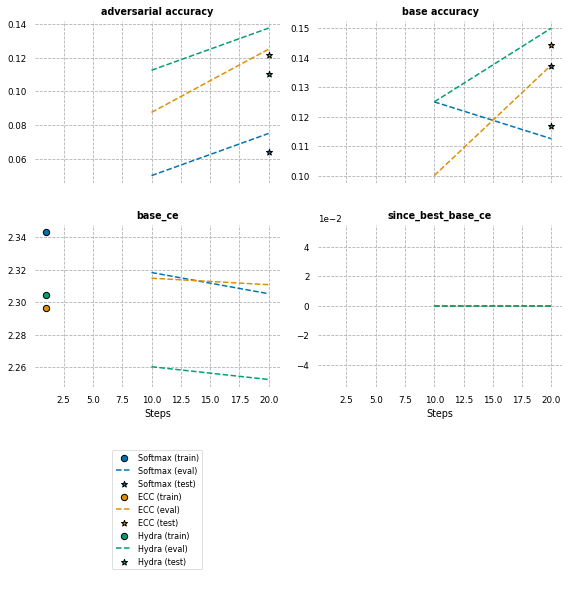

In [15]:
logs = visualize_logs(experiments=[softmax_results, ecc_results, hydra_results], ignore_metrics={'ecc_lr', 'hydra_ecc_lr', 'softmax_lr', 'logging_interval', 'num_device', 'epoch_time', 'min_base_ce', 'adv_ce', 'total_time'})

As you can see, the conventional network using softmax to convert logits to class probabilities actually gets more and more vulnerable to adversarial attacks as training progresses. It also quickly overfits to the data, reaching an optimal performance around epoch 7. By simply switching the softmax layer for an error-correcting-code, the network is able to train for around 16 epochs before starting to cap out, and even then continuing to train it results in better and better adversarial performance. Creating a multi-headed ecc output layer allows still more training and higher peak performances. If you were to run the experiment out to 160 epochs you would find that the adversarial accuracy can reach almost 70% with only a slight accuracy degradation on clean samples (performance still above 70%). This is significantly better performance than networks trained specifically to combat this attack, shown in the [FGSM](../fgsm/fgsm.ipynb) notebook. Note also that their is virtually no additional cost to training using ECC as opposed to softmax in terms of steps/sec. This is a big benefit over FGSM, where the training time for each step is doubled. With these benefits in mind, you may want to consider never using softmax again.